# LSTM

In this notebook, we train an LSTM model to predict whether a given HJ Andrews Site will be dry (0) or wet (1) using a 30-day sliding window of features.

ADASYN is used to address class imbalance, and Optuna is used for hyperparameter selection.

At the bottom of the notebook, we provide a function for practitioners to run inference with our trained models for an inputted site-date combination.

## Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    classification_report
)
from imblearn.over_sampling import ADASYN
import optuna
from optuna.visualization.matplotlib import plot_contour, plot_parallel_coordinate
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)

## Data Preprocessing

In [2]:
# Data Paths
OBS_PATH = "/Users/michaelmurphy/Desktop/usgs_data/obs.parquet"
STATIC_PATH = "/Users/michaelmurphy/Desktop/usgs_data/static_vars.parquet"
DEGREES_PATH = "/Users/michaelmurphy/Desktop/usgs_data/degrees.parquet"

# Load datasets
static_vars_df = pd.read_parquet(STATIC_PATH)
obs_df = pd.read_parquet(OBS_PATH)
degrees = pd.read_parquet(DEGREES_PATH)

obs_df

,NHDPlusID,SiteIDCode,Date,variable,value
0,55000900130309,GSWS01,1980-01-01,Discharge_CMS,0.045505
1,55000900130309,GSWS01,1980-01-02,Discharge_CMS,0.043410
2,55000900130309,GSWS01,1980-01-03,Discharge_CMS,0.048592
3,55000900130309,GSWS01,1980-01-04,Discharge_CMS,0.061872
4,55000900130309,GSWS01,1980-01-05,Discharge_CMS,0.276599
...,...,...,...,...,...
160731,55000900130309,WDLookMcRaeID1,2020-07-08,MaxDepth_Threshold,0.000000
160732,55000900130309,WDLookMcRaeID1,2020-07-08,MaxDepth_Censor,1.000000
160733,55000900130309,WDLookMcRaeID1,2020-08-12,MaxDepth_cm,51.816000
160734,55000900130309,WDLookMcRaeID1,2020-08-12,MaxDepth_Threshold,0.000000


In [3]:
# Pivot static vars (each variable as a column)
static_wide = static_vars_df.pivot(
    index='NHDPlusID', columns='variable', values='value'
).reset_index()

# Pivot obs (Date as rows, variable as columns)
obs_wide = obs_df.pivot_table(
    index=['NHDPlusID', 'Date'], columns='variable', values='value'
).reset_index()

# Merge static features into each site's obs
merged_df = obs_wide.merge(static_wide, on='NHDPlusID', how='left')
merged_df = merged_df.merge(degrees, on='NHDPlusID', how='left')

# Sort and forward-fill
merged_df = merged_df.sort_values(['NHDPlusID', 'Date']).ffill()
merged_df.head()

,NHDPlusID,Date,Discharge_CMS,Flow_Status,HoboWetDry0.05,MaxDepth_Censor,MaxDepth_Threshold,MaxDepth_cm,ArbolateSu,AreaSqKm,...,curv_mean,curv_median,elev_max_cm,elev_mean_cm,elev_median_cm,elev_min_cm,slp_mean_pct,slp_median_pct,In-degree,Out-degree
0,55000900027171,2020-08-12,NaN,0.00,NaN,0.0,0.0,0.0,0.100818,0.0017,...,63.946892,63.048618,66223.0,58209.588235,57898.0,51722.0,63.946892,63.048618,0.0,1.0
1,55000900027173,2020-08-12,NaN,0.75,NaN,1.0,0.0,7.0,0.297666,0.1235,...,42.080586,41.399857,103022.0,88853.689879,88575.0,74487.0,42.080586,41.399857,1.0,1.0
2,55000900027174,2020-08-12,NaN,1.00,NaN,1.0,0.0,5.5,0.410513,0.0923,...,55.872930,56.605061,96559.0,79958.395450,80669.0,63278.0,55.872930,56.605061,0.0,1.0
3,55000900027177,2020-09-03,NaN,0.50,NaN,1.0,0.0,1.0,0.366996,0.1216,...,63.409000,65.848724,72273.0,60448.368421,60738.5,46037.0,63.409000,65.848724,0.0,1.0
4,55000900027180,2020-09-02,NaN,0.50,NaN,1.0,0.0,11.0,1.082607,0.0592,...,21.379627,22.186161,55631.0,49135.785473,48683.0,46107.0,21.379627,22.186161,2.0,1.0


In [4]:
# Create discharge-based wet/dry and combine with HOBO sensor readings
DRY_THRESHOLD = 0.00014
merged_df["wetdry_discharge"] = (merged_df["Discharge_CMS"] >= DRY_THRESHOLD).astype(int)
merged_df["wetdry_final"] = merged_df["HoboWetDry0.05"].fillna(merged_df["wetdry_discharge"])

# Drop irrelevant and other target columns
merged_df = merged_df.drop(columns=["wetdry_discharge", "FromNode", "ToNode", "Flow_Status", "HoboWetDry0.05", "Discharge_CMS"])

print("Final wet/dry distribution:")
print(merged_df["wetdry_final"].value_counts())

Final wet/dry distribution:
wetdry_final
1.0    125708
0.0     32895
Name: count, dtype: int64


In [5]:
target_col = "wetdry_final"

# Fill remaining NaNs
df = merged_df.copy()
df = df.fillna(method='ffill').fillna(method='bfill').fillna(0)

# Extract target, scale numeric features
y_original = df[target_col].astype(int).values
df_numeric = df.select_dtypes(include=[np.number]).drop(columns=[target_col], errors='ignore')

scaler = StandardScaler()
scaled = scaler.fit_transform(df_numeric)
df_scaled = pd.DataFrame(scaled, columns=df_numeric.columns)

# Reconstruct with label for sequence creation
df_scaled_with_label = df_scaled.copy()
df_scaled_with_label[target_col] = y_original

feature_cols = df_numeric.columns.tolist()
print(f"Features: {len(feature_cols)}, Samples: {len(df_scaled_with_label)}")

Features: 22, Samples: 158603


/var/folders/jd/4sjpm6q97knfqgwsf50gr3jh0000gn/T/ipykernel_24903/2558787643.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill').fillna(0)


In [6]:
# Create 30-day sliding window sequences
seq_len = 30

def create_sequences(df, seq_len=30, target_col="wetdry_final"):
    X, y = [], []
    values = df.drop(target_col, axis=1).values
    labels = df[target_col].values
    for i in range(len(df) - seq_len):
        seq = values[i:i+seq_len]
        target = labels[i+seq_len]
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled_with_label, seq_len=seq_len, target_col=target_col)
print(f"Sequences: {X.shape}, Labels: {y.shape}")
print(f"Class distribution — Wet: {int((y > 0.5).sum())}, Dry: {int((y <= 0.5).sum())}")

Sequences: (158573, 30, 22), Labels: (158573,)
Class distribution — Wet: 125708, Dry: 32865


In [7]:
# Apply ADASYN to address class imbalance
n, T, d = X.shape
X_flat = X.reshape(n, T * d)

adasyn = ADASYN(random_state=42)
X_flat_res, y_res = adasyn.fit_resample(X_flat, y.astype(int))
X_res = X_flat_res.reshape(-1, T, d)

print("Original class counts:", np.bincount(y.astype(int)))
print("After ADASYN:", np.bincount(y_res.astype(int)))

# Convert to tensors
X_tensor = torch.tensor(X_res, dtype=torch.float32)
y_tensor = torch.tensor(y_res.reshape(-1, 1), dtype=torch.float32)
print(f"X_tensor: {X_tensor.shape}, y_tensor: {y_tensor.shape}")

Original class counts: [ 32865 125708]
After ADASYN: [125630 125708]
X_tensor: torch.Size([251338, 30, 22]), y_tensor: torch.Size([251338, 1])


## EDA

NameError: name 'site_df' is not defined

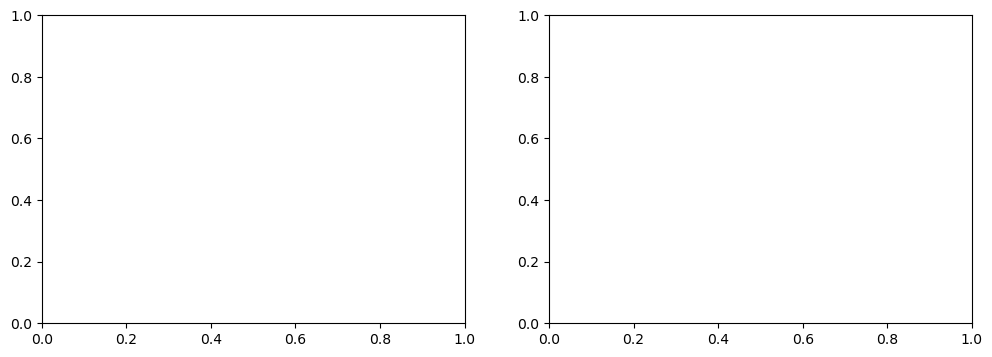

In [8]:
# Class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(x=site_df[target_col], ax=axes[0])
axes[0].set_title("Wet vs Dry Class Distribution")

# Correlation heatmap
numeric_df = df_scaled_with_label.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), cmap='coolwarm', center=0, annot=False, ax=axes[1])
axes[1].set_title("Correlation Heatmap")

plt.tight_layout()
plt.show()

/var/folders/jd/4sjpm6q97knfqgwsf50gr3jh0000gn/T/ipykernel_88872/340321199.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=corr_target.index, x=corr_target.values, palette="viridis")


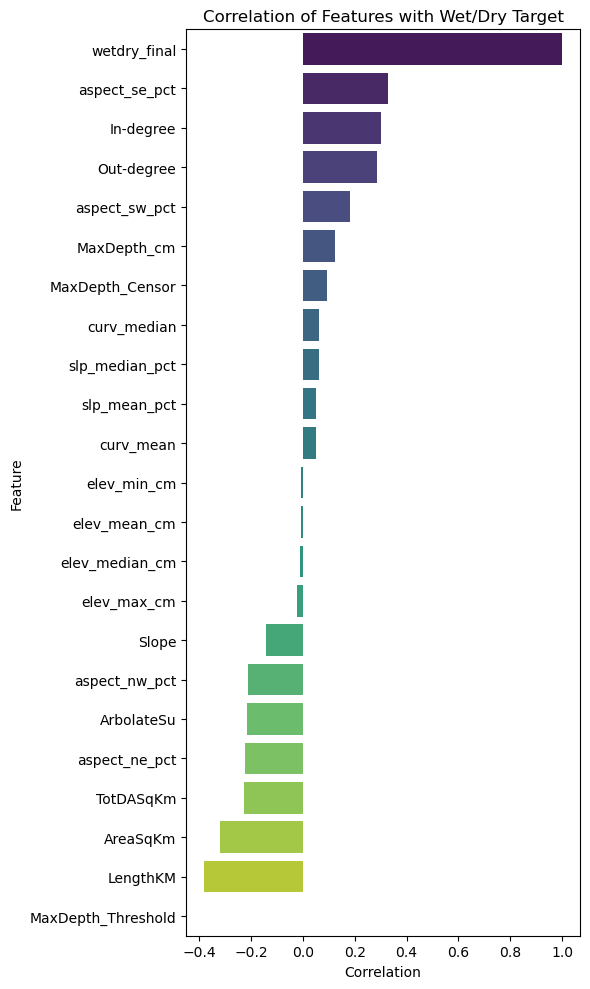

In [ ]:
# Feature correlations with target
corr_target = numeric_df.corr()[target_col].sort_values(ascending=False)

plt.figure(figsize=(6, 10))
sns.barplot(y=corr_target.index, x=corr_target.values, palette="viridis")
plt.title("Correlation of Features with Wet/Dry Target")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [10]:
# Discharge lag scatter plots
lag_df = site_df.copy().sort_values("Date")
lag_df["discharge_lag1"] = lag_df["Discharge_CMS"].shift(1)
lag_df["discharge_lag7"] = lag_df["Discharge_CMS"].shift(7)
lag_df["discharge_lag30"] = lag_df["Discharge_CMS"].shift(30)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.scatterplot(x=lag_df["discharge_lag1"], y=lag_df["Discharge_CMS"], s=10, ax=axes[0])
axes[0].set_title("Discharge vs Lag-1")
axes[0].set_xlabel("Lag 1")
axes[0].set_ylabel("Current")

sns.scatterplot(x=lag_df["discharge_lag7"], y=lag_df["Discharge_CMS"], s=10, ax=axes[1])
axes[1].set_title("Discharge vs Lag-7")
axes[1].set_xlabel("Lag 7")

sns.scatterplot(x=lag_df["discharge_lag30"], y=lag_df["Discharge_CMS"], s=10, ax=axes[2])
axes[2].set_title("Discharge vs Lag-30")
axes[2].set_xlabel("Lag 30")

plt.tight_layout()
plt.show()

KeyError: 'Discharge_CMS'

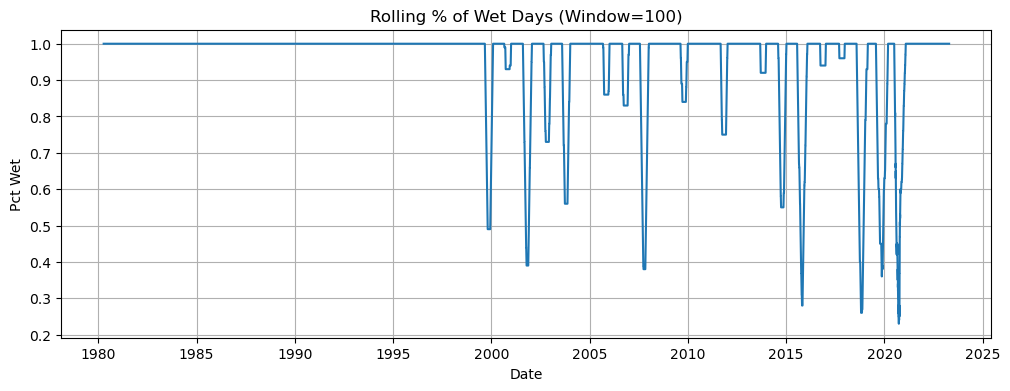

In [11]:
# Rolling wet percentage over time
rolling_df = site_df.copy().sort_values("Date")
rolling_df["rolling_wet"] = rolling_df[target_col].rolling(100).mean()

plt.figure(figsize=(12, 4))
plt.plot(rolling_df["Date"], rolling_df["rolling_wet"])
plt.title("Rolling % of Wet Days (Window=100)")
plt.ylabel("Pct Wet")
plt.xlabel("Date")
plt.grid(True)
plt.show()

/var/folders/jd/4sjpm6q97knfqgwsf50gr3jh0000gn/T/ipykernel_88872/2632522988.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index.astype(str), y=counts.values, palette="plasma")


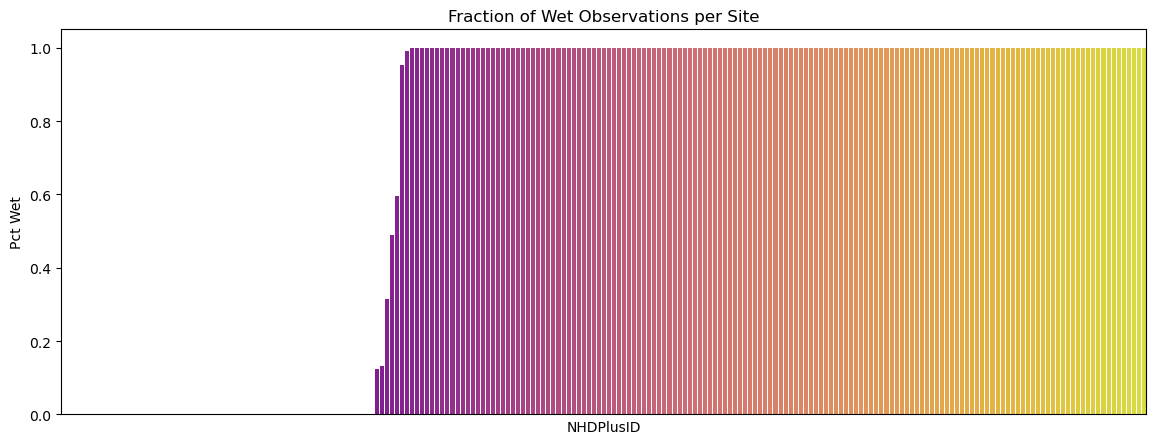

In [12]:
# Fraction of wet observations per site
counts = merged_df.groupby("NHDPlusID")[target_col].mean().sort_values()

plt.figure(figsize=(14, 5))
sns.barplot(x=counts.index.astype(str), y=counts.values, palette="plasma")
plt.xticks([], [])
plt.title("Fraction of Wet Observations per Site")
plt.ylabel("Pct Wet")
plt.show()

## Hyperparameter Selection

In [13]:
# # Split for hyperparameter search
# X_hp_train, X_hp_val, y_hp_train, y_hp_val = train_test_split(
#     X_tensor, y_tensor, test_size=0.2, shuffle=True, random_state=42
# )

# # LSTM model for Optuna (with sigmoid output)
# class LSTMModelHP(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, dropout):
#         super().__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
#         self.fc = nn.Linear(hidden_size, 1)
#         self.sigmoid = nn.Sigmoid()
#     def forward(self, x):
#         out, _ = self.lstm(x)
#         out = self.fc(out[:, -1, :])
#         return self.sigmoid(out)

# # Optuna objective
# def objective(trial):
#     hidden_size = trial.suggest_int("hidden_size", 32, 128)
#     num_layers  = trial.suggest_int("num_layers", 1, 3)
#     dropout     = trial.suggest_float("dropout", 0.0, 0.4)
#     lr          = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
#     batch_size  = trial.suggest_categorical("batch_size", [16, 32, 64])
#     epochs      = 7

#     model = LSTMModelHP(
#         input_size=X_tensor.shape[2],
#         hidden_size=hidden_size,
#         num_layers=num_layers,
#         dropout=dropout
#     )
#     criterion = nn.BCELoss()
#     optimizer = optim.Adam(model.parameters(), lr=lr)

#     train_loader = DataLoader(TensorDataset(X_hp_train, y_hp_train), batch_size=batch_size, shuffle=True)
#     val_loader   = DataLoader(TensorDataset(X_hp_val,   y_hp_val),   batch_size=batch_size, shuffle=False)

#     for epoch in range(epochs):
#         model.train()
#         for xb, yb in train_loader:
#             optimizer.zero_grad()
#             preds = model(xb)
#             loss = criterion(preds, yb)
#             loss.backward()
#             optimizer.step()

#     model.eval()
#     preds, actuals = [], []
#     with torch.no_grad():
#         for xb, yb in val_loader:
#             p = model(xb).squeeze(-1).cpu().numpy()
#             preds.append(p)
#             actuals.append(yb.squeeze(-1).cpu().numpy())

#     preds = np.concatenate(preds)
#     actuals = np.concatenate(actuals)

#     if len(np.unique(actuals)) < 2:
#         return 1.0

#     auc = roc_auc_score(actuals, preds)
#     return 1 - auc  # minimize (1 - AUC)

# # Run Optuna study
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=7)

# print("\nBest Hyperparameters:")
# print(study.best_params)
# print(f"Best Validation AUC: {1 - study.best_value:.4f}")

In [14]:
study_best_params = {'hidden_size': 35,
 'num_layers': 1,
 'dropout': 0.36663963918608383,
 'lr': 0.0014124628060491655,
 'batch_size': 64}

study_best_params

{'hidden_size': 35,
 'num_layers': 1,
 'dropout': 0.36663963918608383,
 'lr': 0.0014124628060491655,
 'batch_size': 64}

In [15]:
# # Contour plot of hyperparameter interactions
# fig = plot_contour(
#     study,
#     params=["hidden_size", "lr"]
# )
# plt.title("Contour Plot: hidden_size vs lr")
# plt.tight_layout()
# plt.show()

In [16]:
# # Parallel coordinate plot
# fig = plot_parallel_coordinate(
#     study,
#     params=["hidden_size", "num_layers", "dropout", "lr", "batch_size"],
#     target=lambda t: 1.0 - t.value,
#     target_name="Validation AUC"
# )
# plt.tight_layout()
# plt.show()

## Model Training

In [9]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X_tensor, y_tensor, test_size=0.2, shuffle=True, random_state=42
)
print("Train:", X_train.shape, "Val:", X_val.shape)

# Define LSTM model (logits output for BCEWithLogitsLoss)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=48, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        logits = self.fc(out[:, -1, :])
        return logits

model = LSTMModel(X_tensor.shape[2])

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.0], dtype=torch.float32))
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)

# Training with early stopping
best_val_loss = float("inf")
best_state = None
patience = 3
wait = 0
epochs = 15

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()

        logits = model(xb)
        logits = torch.nan_to_num(logits, nan=0.0, posinf=5.0, neginf=-5.0)

        loss = criterion(logits, yb)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            logits = torch.nan_to_num(logits, nan=0.0, posinf=5.0, neginf=-5.0)
            val_loss += criterion(logits, yb).item()

    print(f"Epoch {epoch+1}/{epochs} | Train Loss={total_loss/len(train_loader):.4f} | Val Loss={val_loss/len(val_loader):.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = model.state_dict().copy()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_state)
print("Loaded best model state.")

Train: torch.Size([201070, 30, 22]) Val: torch.Size([50268, 30, 22])


/opt/anaconda3/envs/hbmv_2/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/15 | Train Loss=0.1834 | Val Loss=0.1496


KeyboardInterrupt: 

## Metrics and Feature Importance

In [10]:
# Prediction helper
def get_probs(loader):
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb)
            logits = torch.nan_to_num(logits, nan=0.0, posinf=15.0, neginf=-15.0)
            probs = torch.sigmoid(logits).squeeze(-1).cpu().numpy()
            probs = np.nan_to_num(probs, nan=0.0, posinf=1.0, neginf=0.0)
            preds.append(probs)
            actuals.append(yb.squeeze(-1).cpu().numpy())
    out_probs = np.concatenate(preds)
    out_true = np.concatenate(actuals)
    out_true = np.nan_to_num(out_true, nan=0.0)
    return out_probs, out_true

train_probs, train_true = get_probs(train_loader)
val_probs,   val_true   = get_probs(val_loader)

# Sanitize values
train_probs = np.nan_to_num(train_probs, nan=0.0, posinf=1.0, neginf=0.0)
val_probs   = np.nan_to_num(val_probs,   nan=0.0, posinf=1.0, neginf=0.0)
train_true  = np.nan_to_num(train_true, nan=0.0)
val_true    = np.nan_to_num(val_true,   nan=0.0)

# Apply threshold
threshold = 0.5
train_pred = (train_probs >= threshold).astype(int)
val_pred   = (val_probs   >= threshold).astype(int)

# Evaluation
def compute_metrics(y_true, y_prob, y_pred):
    cm   = confusion_matrix(y_true, y_pred)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred)
    auc  = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else float('nan')
    return cm, acc, prec, rec, f1, auc

train_cm, train_acc, train_prec, train_rec, train_f1, train_auc = \
    compute_metrics(train_true, train_probs, train_pred)

val_cm, val_acc, val_prec, val_rec, val_f1, val_auc = \
    compute_metrics(val_true, val_probs, val_pred)

print("TRAIN METRICS")
print(f"Accuracy:  {train_acc:.4f}")
print(f"Precision: {train_prec:.4f}")
print(f"Recall:    {train_rec:.4f}")
print(f"F1 Score:  {train_f1:.4f}")
print(f"AUC:       {train_auc:.4f}")

print("\nVAL METRICS")
print(f"Accuracy:  {val_acc:.4f}")
print(f"Precision: {val_prec:.4f}")
print(f"Recall:    {val_rec:.4f}")
print(f"F1 Score:  {val_f1:.4f}")
print(f"AUC:       {val_auc:.4f}")

print("\nClassification Report (Validation):")
print(classification_report(val_true, val_pred, target_names=['Dry', 'Wet'], digits=3))

TRAIN METRICS
Accuracy:  0.9516
Precision: 0.9999
Recall:    0.9033
F1 Score:  0.9492
AUC:       0.9651

VAL METRICS
Accuracy:  0.9526
Precision: 0.9999
Recall:    0.9051
F1 Score:  0.9501
AUC:       0.9655

Classification Report (Validation):
              precision    recall  f1-score   support

         Dry      0.914     1.000     0.955     25207
         Wet      1.000     0.905     0.950     25061

    accuracy                          0.953     50268
   macro avg      0.957     0.952     0.952     50268
weighted avg      0.957     0.953     0.953     50268



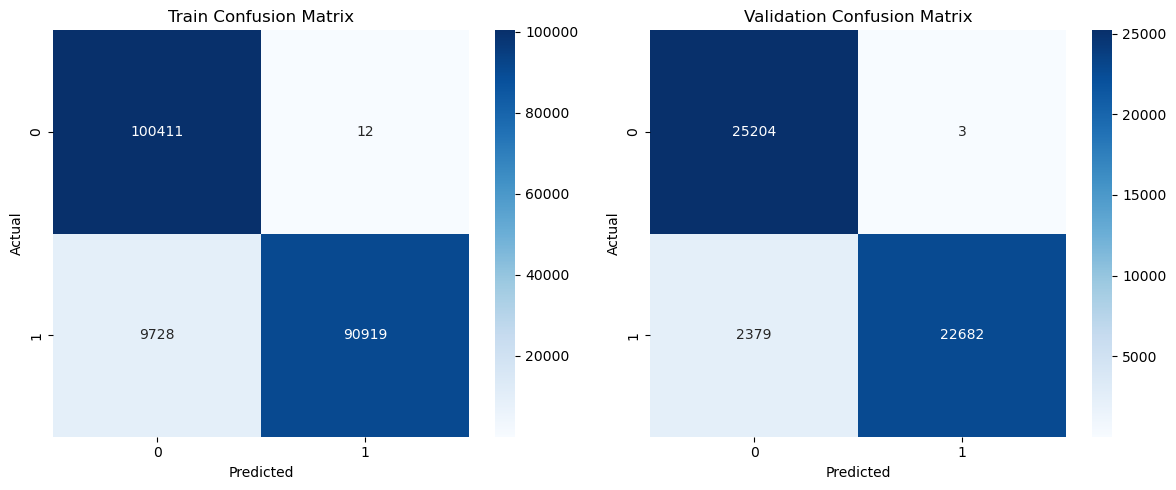

In [11]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Train Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title("Validation Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [12]:
# Permutation importance
def perm_importance(model, X_val, y_val, n_repeats=5):
    base_preds = torch.sigmoid(model(X_val)).detach().cpu().numpy()
    base_f1 = f1_score(y_val, (base_preds > 0.5))

    importances = []
    for col in range(X_val.shape[2]):
        f1_scores = []
        for _ in range(n_repeats):
            X_permuted = X_val.clone()
            X_permuted[:, :, col] = X_val[:, :, col][torch.randperm(X_val.shape[0])]
            perm_preds = torch.sigmoid(model(X_permuted)).detach().cpu().numpy()
            f1_scores.append(f1_score(y_val, (perm_preds > 0.5)))
        importances.append(base_f1 - np.mean(f1_scores))

    return np.array(importances)

imps = perm_importance(model, X_val, y_val.squeeze().numpy())

# Build importance table (feature_cols excludes target, matching model input)
importance = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": imps
})
importance['Abs_Importance'] = importance['Importance'].abs()
importance = importance.sort_values('Abs_Importance', ascending=False)

# Scale to 0-1
importance['Importance_Scaled'] = importance['Abs_Importance'] / importance['Abs_Importance'].max()

print(importance[['Feature', 'Importance']].to_string(index=False))

# Plot top 10
top10 = importance.head(10)

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(top10['Feature'][::-1], top10['Importance_Scaled'][::-1])
ax.set_xlabel('Feature Importance (0-1 Scaled)')
ax.set_title('Top 10 Feature Importances - LSTM (Permutation)')
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

## Inference

In [72]:
def predict_site_date_lstm(model, scaler, site_df, seq_len, site_id, date, target_col="wetdry_final"):
    """
    Predict wet/dry status for a given site and date using LSTM.
    
    Parameters:
    -----------
    model : LSTMModel
        Trained LSTM model
    scaler : StandardScaler
        Fitted scaler for feature normalization
    site_df : pd.DataFrame
        Complete dataset for the site with all features
    seq_len : int
        Sequence length used in training (e.g., 30)
    site_id : str
        Site identifier (e.g., "55000900061097")
    date : str
        Date in format "YYYY-MM-DD"
    target_col : str
        Target column name
    
    Returns:
    --------
    str : Prediction result with probability
    """
    date = pd.to_datetime(date).date()
    site_id = str(site_id)
    
    # Get site data
    site_data = site_df[site_df["NHDPlusID"] == site_id].sort_values("Date")
    
    if site_data.empty:
        return f"No data found for Site {site_id}"
    
    # Find the date index
    date_idx = site_data[site_data["Date"] == date].index
    
    if len(date_idx) == 0:
        return f"No data found for Site {site_id} on {date}"
    
    date_idx = date_idx[0]
    date_pos = site_data.index.get_loc(date_idx)
    
    # Check if we have enough history
    if date_pos < seq_len:
        return f"Not enough historical data (need {seq_len} days) for {date}"
    
    # Extract sequence
    seq_data = site_data.iloc[date_pos - seq_len:date_pos]
    
    # Prepare features
    df_numeric = seq_data.select_dtypes(include=[np.number]).drop(columns=[target_col], errors='ignore')
    seq_scaled = scaler.transform(df_numeric)
    
    # Convert to tensor
    seq_tensor = torch.tensor(seq_scaled, dtype=torch.float32).unsqueeze(0)  # (1, seq_len, features)
    
    # Predict
    model.eval()
    with torch.no_grad():
        logits = model(seq_tensor)
        prob = torch.sigmoid(logits).item()
    
    pred_class = 1 if prob >= 0.5 else 0
    
    return f"Site {site_id} on {date}: {'DRY' if pred_class == 0 else 'WET'}, (P(wet)={prob:.4f})"

In [73]:
# Example inference
predict_site_date_lstm(
    model=model,
    scaler=scaler,
    site_df=merged_df,
    seq_len=30,
    site_id="55000900272714",
    date="2020-10-18",
    target_col="wetdry_final"
)

'Site 55000900272714 on 2020-10-18: DRY, (P(wet)=0.2630)'